In [1]:
from collections import defaultdict

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydec
import scipy.linalg
from scipy.spatial import Delaunay
from shapely.geometry import box, Point

from DDV import eigenbasis, kernel


C:\Users\mg874\anaconda3\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
bbox = (10, 38, -40, -28)
bounding_box = box(bbox[0], bbox[2], bbox[1], bbox[3])

coast = cf.GSHHSFeature(scale="c")

coast_points = []
clip_coast = None
for geom in coast.geometries():
    # Only keep parts within the bounding box
    clipped = geom.intersection(bounding_box)
    if not clipped.is_empty:
        coords = list(clipped.exterior.coords[:-1])
        for coord in coords:
            coast_points.append(coord)
        clip_coast = clipped

points = coast_points.copy()

xs = np.linspace(bbox[0], bbox[1], 44)
ys = np.linspace(bbox[2], bbox[3], 24)

XS, YS = np.meshgrid(xs, ys)

for x, y in zip(XS.ravel(), YS.ravel()):
    pt = Point((x, y))
    if not clip_coast.contains(pt) and clip_coast.distance(pt) > 0.4:
        points.append((x, y))

inner_points_idx = np.array(range(len(points)))

# add outer boundary points

points.append((bbox[0] - 2, bbox[3] + 2))
points.append((bbox[0] - 2, bbox[2] - 2))

points.append((bbox[0] + 2, bbox[3] + 2))
points.append((bbox[0] + 2, bbox[2] - 2))

points.append((bbox[1] + 2, bbox[3] + 2))
points.append((bbox[1] + 2, bbox[2] - 2))
points.append((bbox[1] - 2, bbox[3] + 2))
points.append((bbox[1] - 2, bbox[2] - 2))

points.append((bbox[1] + 2, (1 / 4) * bbox[2] + (3 / 4) * bbox[3]))
points.append((bbox[1] + 2, (2 / 4) * bbox[2] + (2 / 4) * bbox[3]))
points.append((bbox[1] + 2, (3 / 4) * bbox[2] + (1 / 4) * bbox[3]))

points.append((bbox[0] - 2, (1 / 4) * bbox[2] + (3 / 4) * bbox[3]))
points.append((bbox[0] - 2, (2 / 4) * bbox[2] + (2 / 4) * bbox[3]))
points.append((bbox[0] - 2, (3 / 4) * bbox[2] + (1 / 4) * bbox[3]))

points.append(((1 / 4) * bbox[0] + (3 / 4) * bbox[1], bbox[2] - 2))
points.append(((2 / 4) * bbox[0] + (2 / 4) * bbox[1], bbox[2] - 2))
points.append(((3 / 4) * bbox[0] + (1 / 4) * bbox[1], bbox[2] - 2))

points_array = np.array(points)
coast_tri = Delaunay(points_array)

In [3]:
point_status = np.array([pt in coast_points for pt in points])

# 
valid_triangles = []
for simplex in coast_tri.simplices:
    statuses = point_status[simplex]
    if not np.all(statuses):
        # All on land or all in water → keep
        valid_triangles.append(simplex)

filtered_triangles = np.array(valid_triangles)

In [4]:
coast_complex = pydec.SimplicialComplex((coast_tri.points, filtered_triangles))
coast_complex.construct_hodge()

coast_boundary = []
for bs in coast_complex.boundary():
    b1, b2 = bs
    v1b1, v2b1 = coast_complex.vertices[b1]
    v1b2, v2b2 = coast_complex.vertices[b2]
    if ((v1b1, v2b1) in coast_points) or ((v1b2, v2b2) in coast_points):
        coast_boundary.append(bs)

In [5]:
def gen_boundary_vert_norms(c, boundary):
    def unpack(b):
        for v1, v2 in b:
            yield v1
            yield v2

    edge_norms = {}
    vert_norms = {}
    vertex_to_edge = defaultdict(list)
    for boundary_simplex in boundary:
        v1, v2 = boundary_simplex

        vertex_to_edge[v1].append(boundary_simplex)
        vertex_to_edge[v2].append(boundary_simplex)

        # find 3rd vertex of triangle containing edge
        v3 = None
        for t in c[2].simplices:
            if v1 in t and v2 in t:
                for v in t:
                    if v != v1 and v != v2:
                        v3 = v

        vert1, vert2, vert3 = c.vertices[v1], c.vertices[v2], c.vertices[v3]

        c_point = (vert1 + vert2) / 2
        e1 = vert2 - vert1
        e2 = c_point - vert3
        norm = (-e1[1], e1[0])

        sign = np.sign(np.dot(e2, norm))
        norm = sign * (norm / np.linalg.norm(norm))

        edge_norms[boundary_simplex] = norm

    for b in set(unpack(boundary)):
        if len(vertex_to_edge[b]) == 2:
            b1, b2 = vertex_to_edge[b]
            norm = (edge_norms[b1] + edge_norms[b2]) / 2

            vert_norms[b] = norm

    return vert_norms


coast_normals = gen_boundary_vert_norms(coast_complex, coast_boundary)

In [6]:
reduced_boundary = []
for bs in coast_complex.boundary():
    b1, b2 = bs
    v1b1, v2b1 = coast_complex.vertices[b1]
    v1b2, v2b2 = coast_complex.vertices[b2]
    if ((v1b1, v2b1) in coast_points) and ((v1b2, v2b2) in coast_points):
        reduced_boundary.append(bs)

coast_eigenvalues, coast_div_eigenfields, coast_curl_eigenfields, coast_vol, _ = eigenbasis.generate_vector_basis(
    complex=coast_complex, boundary=reduced_boundary, flat=True, depth=500)

Processing eigenvectors:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [7]:
drifter_df = pd.read_csv("../data/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr_1744112494818.csv")
drifter_df.loc[(drifter_df['parameter'] == "EWCT")].time.unique()

array(['2025-03-15T12:00:00.000Z', '2025-03-15T13:00:00.000Z',
       '2025-03-15T14:00:00.000Z', '2025-03-15T15:00:00.000Z',
       '2025-03-15T16:00:00.000Z', '2025-03-15T17:00:00.000Z',
       '2025-03-15T18:00:00.000Z', '2025-03-15T19:00:00.000Z',
       '2025-03-15T20:00:00.000Z', '2025-03-15T21:00:00.000Z',
       '2025-03-15T22:00:00.000Z', '2025-03-15T23:00:00.000Z',
       '2025-03-16T00:00:00.000Z', '2025-03-16T01:00:00.000Z',
       '2025-03-16T02:00:00.000Z', '2025-03-16T03:00:00.000Z',
       '2025-03-16T04:00:00.000Z', '2025-03-16T05:00:00.000Z',
       '2025-03-16T06:00:00.000Z', '2025-03-16T07:00:00.000Z',
       '2025-03-16T08:00:00.000Z', '2025-03-16T09:00:00.000Z',
       '2025-03-16T10:00:00.000Z', '2025-03-16T11:00:00.000Z',
       '2025-03-16T12:00:00.000Z', '2025-03-16T13:00:00.000Z',
       '2025-03-16T14:00:00.000Z', '2025-03-16T15:00:00.000Z',
       '2025-03-16T16:00:00.000Z', '2025-03-16T17:00:00.000Z',
       '2025-03-16T18:00:00.000Z', '2025-03-16T19:00:00

In [8]:
df_time = "2025-03-16T17:00:00.000Z"
filtered_df = drifter_df.loc[(drifter_df['time'] == df_time) & (drifter_df['depth'] == 15)]

eastings = filtered_df.loc[(filtered_df['parameter'] == "EWCT")].value.to_numpy()
northings = filtered_df.loc[(filtered_df['parameter'] == "NSCT")].value.to_numpy()
longs = filtered_df.loc[(filtered_df['parameter'] == "EWCT")].longitude.to_numpy()
lats = filtered_df.loc[(filtered_df['parameter'] == "EWCT")].latitude.to_numpy()

closest_points = []
closest_points_idx = []

for ll in zip(longs, lats):
    p_idx = scipy.spatial.KDTree(points_array).query(ll)[1]
    closest_points_idx.append(p_idx)
    point = points_array[p_idx]
    closest_points.append(point)

closest_points = np.array(closest_points)

In [9]:
params = {
    "k_d": 5,
    "k_c": 50,
    "s_d": 0.5,
    "s_c": 2.5,
    "v": 1.5
}

post_mean, post_cov = kernel.predict_vectors(coast_eigenvalues, coast_div_eigenfields, coast_curl_eigenfields,
                                             np.array(closest_points_idx), range(len(coast_tri.points)),
                                             np.column_stack((eastings, northings)),
                                             dim=2, params=params, vol=coast_vol, tau=1e-6, cov=True)

Condition number of K_vec_x_x: 4.99e+03
Generating posterior covariance...
Condition number of K_vec_x_star_x_star: 2.98e+09
min eigval: 9.999991394932765e-07
rank (eig > 1e-10): 1640 / 1640


Processing eigenvectors:   0%|          | 0/500 [00:10<?, ?it/s]

Average mean easting: -0.030093488032043196, average obs easting: -0.1851
Average mean northing: 0.08085947025447333, average obs northing: -0.020299999999999985
scale: 17.808853443169426


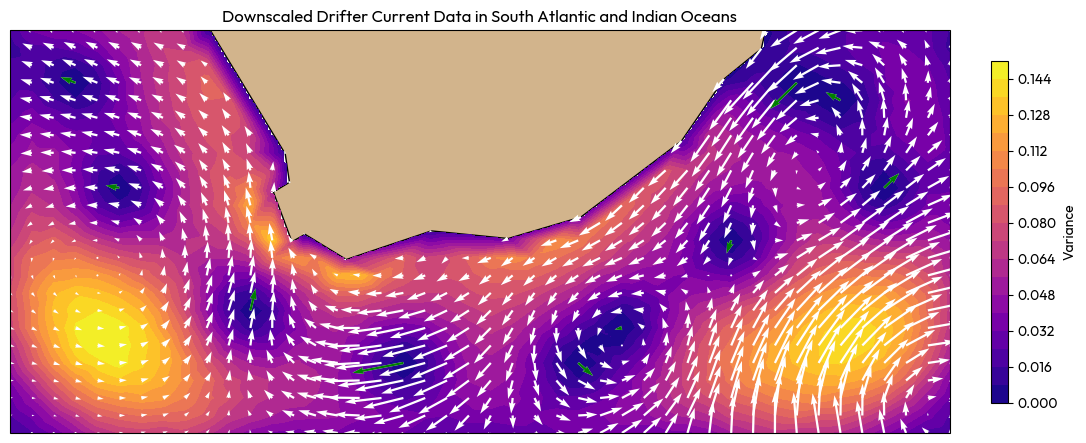

In [10]:
# predicted_vecs = reproject_boundary_vectors(post_mean, reduced_boundary, coast_normals)

predicted_vecs = post_mean

scalar_uncertainty = np.zeros(len(coast_tri.points))

for i in range(len(coast_tri.points)):
    block = post_cov[2 * i:2 * i + 2, 2 * i:2 * i + 2]
    scalar_uncertainty[i] = np.trace(block)

fig = plt.figure(figsize=(11, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(coast, edgecolor='black', facecolor='tan', zorder=1)

points = coast_complex.vertices[inner_points_idx]  # shape (N, 2)
values = scalar_uncertainty[inner_points_idx]

xi = np.linspace(points[:, 0].min(), points[:, 0].max(), 300)
yi = np.linspace(points[:, 1].min(), points[:, 1].max(), 300)
xi, yi = np.meshgrid(xi, yi)

zi = scipy.interpolate.griddata(points, values, (xi, yi), method='linear')

grid_points = np.vstack([xi.ravel(), yi.ravel()]).T

mask = np.array([clip_coast.contains(Point(pt)) for pt in grid_points])
mask = mask.reshape(xi.shape)

# Apply the mask to interpolated values
zi_masked = np.where(mask, np.nan, zi)

valid_zi = zi_masked[~np.isnan(zi_masked)]
vmin = valid_zi.min()
vmax = valid_zi.max()

cf = ax.contourf(xi, yi, zi_masked, levels=20, cmap='plasma', vmin=vmin, vmax=vmax)

Q = ax.quiver(coast_complex.vertices[inner_points_idx, 0], coast_complex.vertices[inner_points_idx, 1],
              predicted_vecs[inner_points_idx, 0], predicted_vecs[inner_points_idx, 1], color='white')
Q._init()

ax.quiver(closest_points[:, 0], closest_points[:, 1], eastings, northings, color='green', scale=Q.scale, width=Q.width)
# ax.plot(closest_points[:, 0], closest_points[:, 1], 'rx')

print(f"Average mean easting: {np.mean(predicted_vecs[:, 0])}, average obs easting: {np.mean(eastings)}")
print(f"Average mean northing: {np.mean(predicted_vecs[:, 1])}, average obs northing: {np.mean(northings)}")
print(f"scale: {Q.scale}")
cbar = plt.colorbar(mappable=cf, fraction=0.04, pad=0.04, shrink=0.6)
cbar.set_label('Variance')
plt.tight_layout()
# plt.show()

plt.savefig('plots/ocean-current.png', dpi=400)

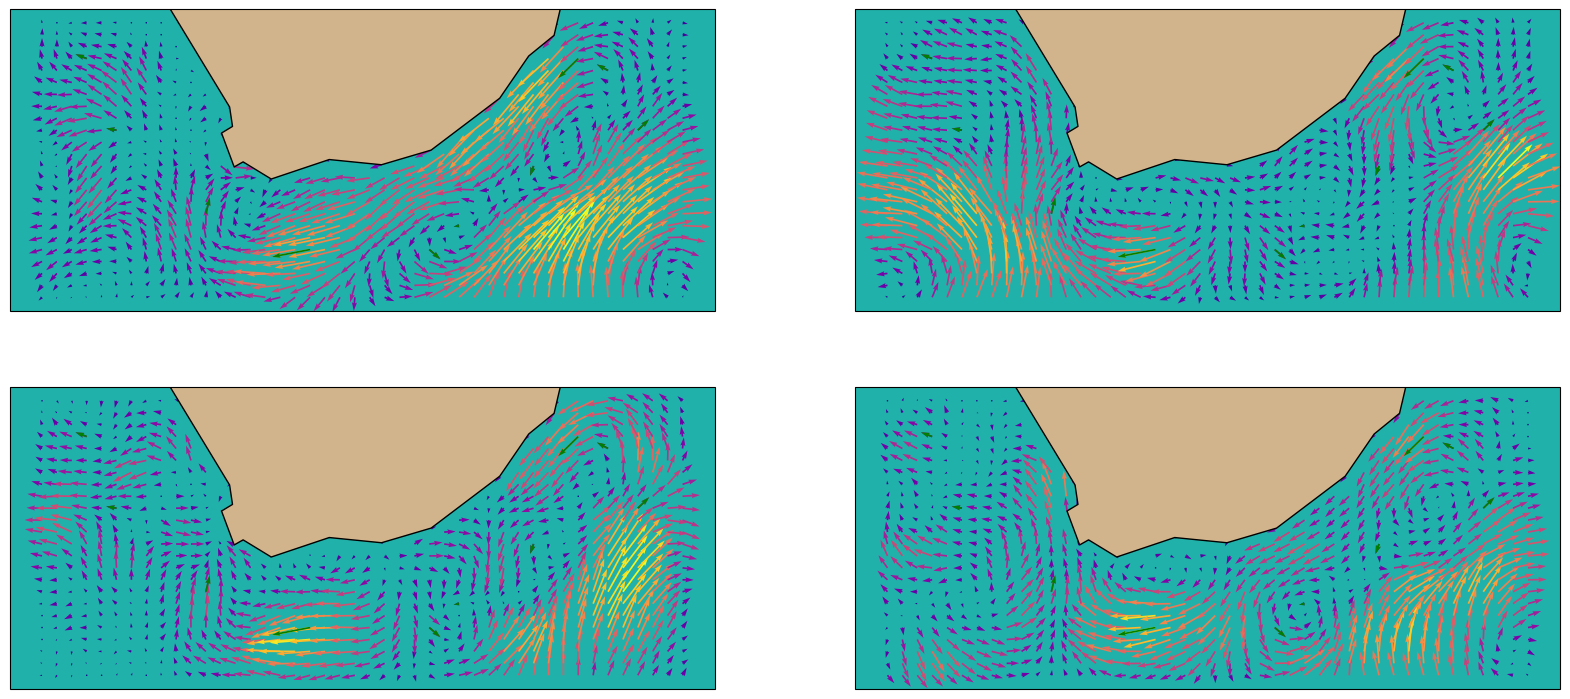

In [63]:
def draw_posterior_samples(post_mean, post_cov, num_samples=1):
    flat_mean = post_mean.reshape(-1)
    L = np.linalg.cholesky(post_cov)

    z = np.random.normal(size=(len(flat_mean), num_samples))

    samples_flat = flat_mean[:, None] + L @ z

    return samples_flat.T.reshape((-1,) + post_mean.shape)


vsample = draw_posterior_samples(post_mean, post_cov, num_samples=4)

fig, axs = plt.subplots(2, 2, figsize=(20, 9), subplot_kw={'projection': ccrs.PlateCarree()})

quiver_obj = None

for i in range(2):
    for j in range(2):
        axs[i, j].set_facecolor('lightseagreen')
        axs[i, j].add_feature(coast, edgecolor='black', facecolor='tan')
        q = axs[i, j].quiver(coast_complex.vertices[inner_points_idx, 0], coast_complex.vertices[inner_points_idx, 1],
                             vsample[i * 2 + j, inner_points_idx, 0], vsample[i * 2 + j, inner_points_idx, 1], np.sqrt(
                np.power(vsample[i * 2 + j, inner_points_idx, 0], 2) + np.power(vsample[i * 2 + j, inner_points_idx, 1],
                                                                                2)), cmap='plasma', scale=Q.scale)
        axs[i, j].quiver(closest_points[:, 0], closest_points[:, 1], eastings, northings, color='green', scale=Q.scale,
                         width=Q.width)

        if quiver_obj is None:
            quiver_obj = q

# fig.suptitle("Posterior Samples from GP Conditioned on Observed Drifter Data", y=0.91)